In [1]:
import foolbox
import PIL.Image as Image
import numpy as np
import matplotlib.pyplot as plt

import torchvision.models as models
import numpy as np
import torchvision.transforms as transforms
from vector_fields import draw_vector_field
from foolbox.criteria import Misclassification
from foolbox.criteria import TopKMisclassification
from foolbox.criteria import TargetClass

model = models.resnet50(pretrained=True).cuda() # Use WIDTH = 224
for param in model.parameters():
    param.requires_grad = False
model.eval()

# ADef config
candidates = 1          # The only candidate is the one with the second highest score
max_iter = 100          # Maximum number of iterations
max_norm = np.inf       # Maximum norm of the vector field
sigma = 1.0               # Parameter for the smoothing of the vector field


image, label = foolbox.utils.imagenet_example()
image_resh = np.transpose(image,(2,0,1)) / 255.0  # C, H, W

#preprocessing = np.array([[0.485, 0.456, 0.406],[0.485, 0.456, 0.406]])
preprocessing = (np.array([0.485, 0.456, 0.406]).reshape((3,1,1)),np.array([0.229, 0.224, 0.225]).reshape((3,1,1)))

fmodel = foolbox.models.PyTorchModel(model, bounds=(0, 255), preprocessing=preprocessing, num_classes=1000)

attack = foolbox.attacks.ADefAttack(model=fmodel, criterion=TargetClass(281))
#attack = foolbox.attacks.ADefAttack(fmodel)


adversarial = attack(image_resh, label, max_norm=max_norm, max_iter=max_iter, smooth=sigma)


vector_field = attack.vector_field


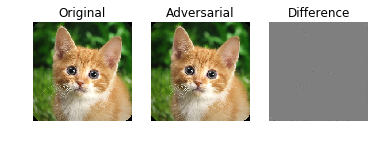

In [2]:
plt.figure()

original_title = 'Original'
plt.subplot(1, 3, 1)
plt.title(original_title)
plt.imshow(image / 255)  # division by 255 to convert [0, 255] to [0, 1]
plt.axis('off')

adv_title = 'Adversarial'
plt.subplot(1, 3, 2)
plt.title(adv_title)
plt.imshow(np.transpose(adversarial,(1,2,0)))  # ::-1 to convert BGR to RGB
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Difference')
difference = np.transpose(adversarial,(1,2,0))*255.0- image
plt.imshow(difference / abs(difference).max() * 0.2 + 0.5)
plt.axis('off')

plt.show()

In [3]:
pertl2 = np.linalg.norm( image.ravel()/255.0 - (np.transpose(adversarial,(1,2,0))).ravel(), ord=2 )
pertlinf = np.linalg.norm( image.ravel()/255.0 - (np.transpose(adversarial,(1,2,0))).ravel(), ord=np.inf )
# Size of vector field:
vecnorms = np.sqrt( vector_field[:,:,0]**2 + vector_field[:,:,1]**2 )
vfl2 = np.linalg.norm( vecnorms.ravel(), ord=2 )
vfT = np.linalg.norm( vecnorms.ravel(), ord=np.inf )

Drawing 4441 arrows


Text(0.5,0,'$\\ell^2$-norm: 0.536,  $\\ell^\\infty$-norm: 0.058')

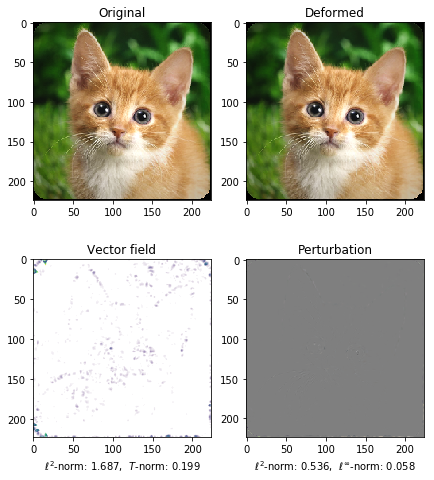

In [4]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
fig.set_size_inches(7,8)

ax1.imshow( image/255 )
ax2.imshow( np.transpose(adversarial,(1,2,0)) )
bg_image = np.transpose(adversarial,(1,2,0))*255//2 + 128
#ax3.imshow( bg_image.astype(int) )
draw_vector_field( ax3, vector_field, amp=40, tol=0.01 )
difference = np.transpose(adversarial,(1,2,0))*255.0- image
ax4.imshow(difference / abs(difference).max() * 0.2 + 0.5) 

ax1.set_title( 'Original' )
ax2.set_title( 'Deformed' )
ax3.set_title( 'Vector field' )
ax4.set_title( 'Perturbation' )

ax3.set_xlabel(r'$\ell^2$-norm: %.3f,  $T$-norm: %.3f' %( vfl2, vfT ) )
ax4.set_xlabel(r'$\ell^2$-norm: %.3f,  $\ell^\infty$-norm: %.3f' %( pertl2, pertlinf ) )